# Microfossils, Remote Sensing, and GIS for Proxy-dating Coastal Archaeological Sites and Landscapes: A case from Minas Basin, Bay of Fundy, Canada

This Jupyter Notebook is intended to replicate the production of geochronological *terminus ante quem* boundaries for the Kingsport marsh as described in the associated article. 

Loading this *AppendixB* Jupyter Notebook as a Binder increases reproducability of the workflow employed to create the geochronological boundaries.

#### Import Packages & Define Root

The first step is to import the required Python packages to replicate the method presented in the associated article. 

The first chunk in the following block of code imports the required packages. The first two lines of the last chunk sets environment parameters to not import layers produced in geoprocessing to the active map frame, and allow outputs to be overwritten by our Notebook. The last two lines create a variable for our the open map frame in our project so we can more easily display our final outputs in later.

In [ ]:
import numpy as np
import pandas as pd
import iosacal
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os


from ipyleaflet import *
%matplotlib inline

from pprint import pprint
from numpy import ones,vstack
from numpy.linalg import lstsq
from iosacal import R, iplot
from iosacal.text import single_text
from pandas import *
from matplotlib import pyplot, figure

tms = True,

Next, we will preview the map frame we will be using by running the following code block.

In [ ]:
mapFrame = Map(basemap=basemaps.Esri.WorldImagery, center=(45.1562107, -64.3699627), zoom=15, max_zoom=17)
basemap = LocalTileLayer(name="Shaded Relief",tms = True, path="minasBase/{z}/{x}/{y}.png")
mapFrame.add_layer(basemap)
measure = MeasureControl(position='bottomleft',active_color = 'orange',primary_length_unit = 'meters')
mapFrame.add_control(measure)
measure.completed_color = 'red'
mapFrame.add_control(FullScreenControl(position='topright'))
mapFrame.add_control(ScaleControl(position='topright', metric=True))
mapFrame.add_control(LayersControl(position='topleft'))
mapFrame

#### Examine open layers

The open map on the left displays datasets that will help explore the output surface after running this notebook. Feel free to explore the LiDAR data of Kingsport marsh.

## Data Preparation

Following the data preparation steps outlined in the methods section of the associated article, we have placed a CSV titled **Appendix A**  within the */data* folder. The following codeblock will display the *AppendixA.csv* file as a table.
<br><br>
The first line calls the CSV from the location within the project folder and loads it into a 'pandas' dataframe called *AppendixA*. Our second line defines formatting, cell alignment, and styles to be applied when we call the variable *Table*. *Table* is called in the third line and our formatted CSV is shown below.

In [ ]:
AppendixA = pd.read_csv("./data/AppendixA.csv")
Table = AppendixA.style.format({"error": lambda x: "±{:.1f}".format(abs(x))}, na_rep="-").format({"date": lambda x: "{:.1f} C14BP".format(float(x))}).format({"core_depth": lambda x: "{:.2f}m".format(abs(x))}, na_rep="-").format({"modern_HHW": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"HHW_corrected": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"modern_HHW": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"HHW_error": lambda x: "±{:.2f}m".format(float(x))}, na_rep="-").set_properties(subset=["error", "core_depth", "modern_HHW", "HHW_corrected", "HHW_error"], **{'text-align': 'center'}).set_properties(subset=["date"], **{'text-align': 'right'})
Table

### Radiocarbon Calibration

The python package IOSACal is used in the following to calibrate the radiocarbon dates obtained from samples at Kingsport. IOSACal does not yet come with the MARINE20 or INTCAL20 calibration curves. The .14c calibration curve files were obtained from the most recent OxCal distribution and copied into the *data* folder of the IOSACal package within the custom Python environment. This ensures that we can use the newest calibration curves directly in this Notebook using Python.

#### Marine Resevoir Correction

Now that we have our CSV holding the necessary data to begin, we need to correct for marine resevoir effect, then calibrate our radiocarbon dates. Mentioned in the associated article, the ΔR of -64 ±90 is subtracted from each radiocarbon date *before* calibration occurs. The codeblock below will perform this calculation. As per usual, when addition or subtraction between two values with reported errors, the errors are summed.

In [ ]:
AppendixA["date"] = AppendixA["date"] - (-64)
AppendixA["error"] = AppendixA["error"] + (90)
Table

#### Calibrating Sample Data

The two codeblocks below will loop through the records in the above table, outputting graphics and a short report for each of the dates.<br>

The first three lines of code define the variables <i>s</i>, <i>d</i>, & <i>e</i> as values from specified columns in our dataframe (<i>ID</i>, <i>date</i>, & <i>error</i>). The following two lines initialize empty lists, *cal68* and *cal95*, that will store the minimum and maximum date of each confidence interval for each sample.<br>

In [ ]:
s = AppendixA.ID.values
d = AppendixA.date.values
e = AppendixA.error.values
cal68 = []
cal95 = []

A lot worthy of explaination happens in the following 9 lines of code.<br>

Beginning with line 1, the following text described the process of our loop line by line.<br>

Line 1 is the header of our **for** loop. The header defines the parameters of our loop, and describes the conditions to be met **for** the loop to stop. Our conditions state iterate the body of the loop below **for** a number of times equal to the <b>range</b> of <b>axis</b> 0, or rows, in <i>AppendixA</i>. We have three samples, so the loop will iterate a total of three times with the provided data.<br>

Line 2 begins the body of the loop by defining a variable called <i>r</i> as equal to the values of date (<i>d</i>), error (<i>e</i>), and ID (<i>s</i>). The variables are designated as radiocarbon dates with the variable <i>R</i> (shorthand in IOSACal). The <i>i</i> in square brackets following <i>d</i>, <i>e</i>, and <i>s</i> is a reference to the value of <i>date</i>, <i>error</i>, and <i>ID</i> for the record with an index matching the current iteration of the loop. The <i>r</i> variable now holds a list containing the three values for each of the three samples. <br>

Line 3 passes the values of our list stored in <i>r</i> to the <b>calibrate</b> method in IOSACal. By prefixing <b>r.</b> to <b>calibrate</b> we are defining that the values in *r* will will be calibrated using the <i>marine20</i> .14c file in parentheses. The calculated values are saved in the variable <i>cal_r</i>. <br>

Line 4 creates a report for the calibration, saved to the variable - <i>report</i>.<br>

On line 5, we search the output report text for digits, storing them in as a list in the variable called <b>findDigits</b>. Line 6 and 7 append the min and max values from our <b>findDigits</b> list for the 68% and 95% confidence intervals, based on their position in the list. These lines take advantage of the consistent structure IOSACal uses for reporting to allow us to directly use the outputs in further analysis.<br>

Lines 8 and 9 then **print** the report stored in our *report* variable below our code, and creates and saves a visualization of the calibration to the directory - */SupplementaryData/output* as a JPG image named by *ID*.

In [ ]:
for i in range(AppendixA.shape[0]):
    r = R(d[i], e[i], s[i])
    cal_r = r.calibrate('marine13')
    report = (single_text(cal_r))
    findDigits = [int(s) for s in re.findall(r'\b\d+\b', report)]
    cal68.append(findDigits[7:9])
    cal95.append(findDigits[13:15])
    print(report)
    iplot(cal_r, output = "\output\\" + s[i] + ".jpg")

To help visualize our results, the three probabibility distributions of calibrated dates created above are shown in the images below:

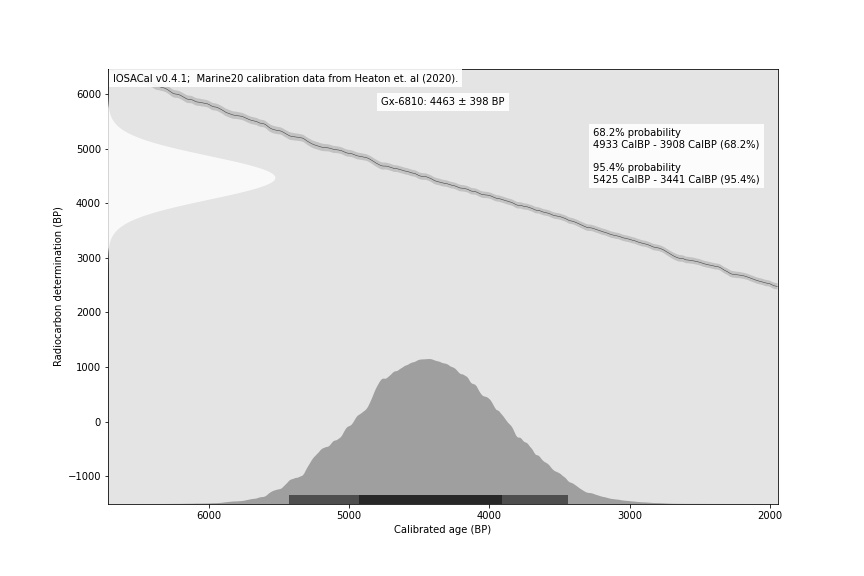
<i><center><small>Probability distribution of calibrated dates from Gx-6810.</small></center></i><br><br><br><br>

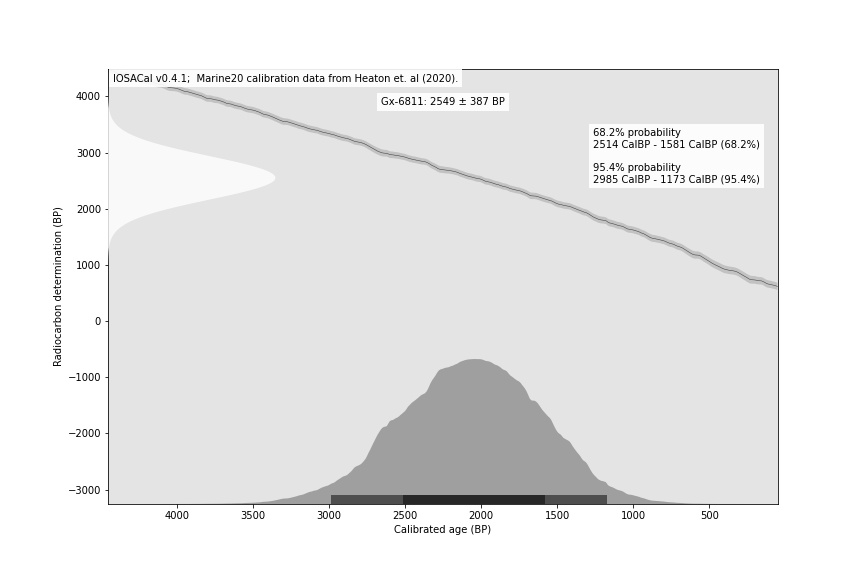
<i><center><small>Probability distribution of calibrated dates from Gx-6811.</small></center></i><br><br><br><br>

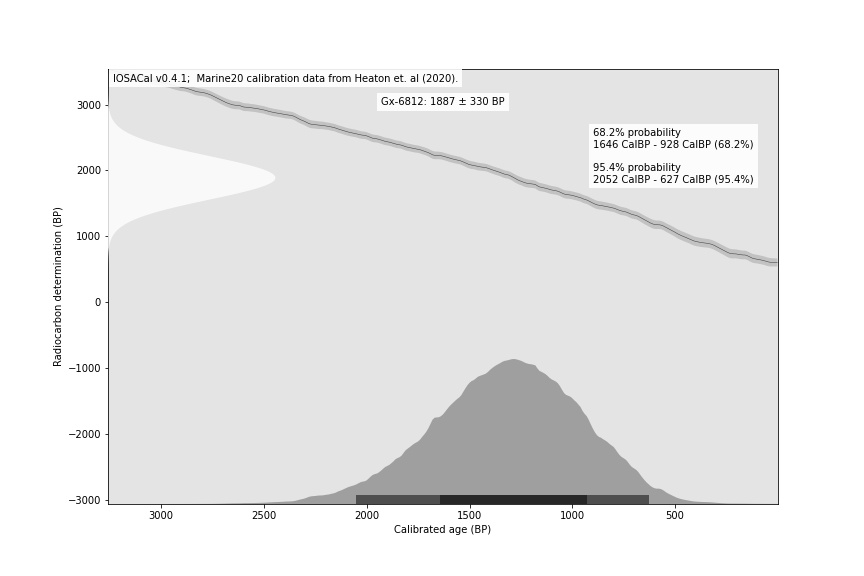
<i><center><small>Probability distribution of calibrated dates from Gx-6812.</small></center></i>

Before we produce our geochronological *terminus ante quem* boundaries. The code below uses another **for** loop to loop through our *cal68* list calculating and appending mean and standard deviation of each calibrated date range to the *AppendixA* dataframe.

Line 1 and line 2 define input variables of the **for** loop as:

- a NumPy array holding the min and max calibrated dates in *cal68*, and
- a list of *index* values within *AppendixA*.

The loop header on Line 3 matches the header of our previous loop to iterate for the total number of records in *AppendixA*.

Line 4 and line 5 define the new *date* and *error* values for the record referenced by *i* in the current loop iteration. The calculated values are the mean and standard deviation for each record in the 68% confidence interval.

In [ ]:
cal68date = np.array(cal68)
i = AppendixA.index.values
for i in range(AppendixA.shape[0]):
    d[i] = (cal68date[i,0]+cal68date[i,1])/2
    e[i] = (cal68date[i,0]-cal68date[i,1])/2

Now we can modify our formatted *Table* dataframe, and visualize the result of our calibration.

In [ ]:
Table = AppendixA.style.hide_index().format({"error": lambda x: "±{:.1f}".format(abs(x))}, na_rep="-").format({"date": lambda x: "{:.0f} CalBP".format(float(x))}).format({"core_depth": lambda x: "{:.2f}m".format(abs(x))}, na_rep="-").format({"modern_HHW": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"HHW_corrected": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"modern_HHW": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"HHW_error": lambda x: "±{:.2f}m".format(float(x))}, na_rep="-").set_properties(subset=["error", "core_depth", "modern_HHW", "HHW_corrected", "HHW_error"], **{'text-align': 'center'}).set_properties(subset=["date"], **{'text-align': 'left'})
Table

## Production of Geochronological Boundaries

### Calculating Sample Elevation

With the radiocarbon calibration complete, we can now begin to produce the geochronological *terminus ante quem* boundaries. Our first step is to calculate the elevation of the radiocarbon dated samples. These elevations will be used to derive past HHW in the CGVD2013 vertical datum.

The codeblock below subtracts *core_depth* from *modern_HHW* and places the result in the *HHW_corrected* column.

In [ ]:
AppendixA["HHW_corrected"] = AppendixA["modern_HHW"]-AppendixA["core_depth"]
Table

One sample, <i>Gx-6811</i>, was located within high marsh Zone 1b. The upper limit of Zone 1b will be 20cm below the limit of HHW mesasured from the top of Zone 1a.

The errors provided for <i>Gx-6811</i> cannot be reduced, but we can correct elevation to match the marine limit by adding the 20cm range in elevation for Zone 1a to the Zone 1b sample elevation.

The codeblock below performs this correction, then displays the updated values in our <i>AppendixA</i> dataframe.

In [ ]:
AppendixA.iloc[1:2,5] = AppendixA.iloc[1:2,5]+0.2
Table

### Determining Relative Sea Level Rise

Our calculated HHW values for the Kingsport sample dates are shown above.

Next step is to determine the amount of RSL rise that has occurred since 1980 at the Kingsport sample locations. In order to do this, two coordinate pairs are required. Variables are defined below for our <i>x1</i>, <i>y1</i>, <i>x2</i>, and <i>y2</i> coordinates. Variable <i>x1</i> represents the radiocarbon equivalent date for the year 2020, where the value 0 is equal to the year 1950.

In [ ]:
x1 = -70
x2 = AppendixA.loc[2].at["date"]
y1 = AppendixA.loc[2].at["modern_HHW"]
y2 = AppendixA.loc[2].at["HHW_corrected"]

We use our coordinate pairs from our table to derive the equation for the linear relationship between the most recent of the radiocarbon dated samples (*Gx-6812, HHW_corrected*) and modern HHW for that sample (*Gx-6812, modern_HHW*) following a  slightly modified codeblock ["from Stack Overflow"](https://stackoverflow.com/a/21566184). This equation will be used to solve for the HHW in the year 1980 by solving for x = -30 in the two following codeblocks. 

The first codeblock creates an object called *coords* from our *x1, y1*, and *x2, y2* coordinate pairs of date and elevation. We then use <b>zip()</b> to sort these pairs into *x_coords* and *y_coords* lists. The third line creates the coefficient matrix (*A*) for the least squares method, <b>lstsq()</b>, on line 4. The two derived values are the slope (<i>m</i>) and intercept (<i>c</i>) of our equation, printed below.

In [ ]:
coords = [(x1,y1),(x2,y2)]
x_coords, y_coords = zip(*coords)
A = vstack([x_coords,ones(len(x_coords))]).T
m, c = lstsq(A, y_coords, rcond=None)[0]
print("Equation is y = {:.5f}x + {:.5f}".format(m,c))

Our output equation is: $$y = -0.00230x + 6.63404$$<br>

The following two codeblocks perform two calculations. First, a modeled HHW elevation value is calaculated for Kingsport in 1980 by solving for <i>y</i>, where: $$x = -30$$<br>  Next, RSL rise since 1980 at HHW is calculated from the difference in HHW compared to 2020.<br>

The following codeblock can also be expressed as: $$HHW_{1980} = 0.00230(-30) + 6.63404$$<br>

Our sea level rise calculation in the second codeblock is expressed as: $$RSLR_{[1980,2020]} = HHW_{2020} - (0.00230(-30) + 6.6340)$$<br>



In [ ]:
SL = m * (-30) + c

print("Higher high water was", "{:.3f}m".format(SL),"CGVD2013 at Kingsport in 1980.")

In [ ]:
SLR = y1 - SL
SLRcm = SLR*100

print("Sea level has risen", "{:.1f}cm".format(SLRcm),"since 1980 at Kingsport.")

As our <i>HHW_corrected</i> elevations for the Kingsport core samples are calculated as values for the year 2020, we need to correct the elevations to match depth below 1980 HHW. The calculation is performed in the codeblock below and expressed as: $$HHW\_corrected_{AppendixA} = HHW\_corrected_{AppendixA} - SLR$$

In [ ]:
AppendixA["HHW_corrected"] = AppendixA["HHW_corrected"] - SLR
Table

### Calculating Equvalent HHW at Oak Point

An equivalent HHW elevation at Oak Point is obtained for each calibrated date by correcting for SLR and sample elevation.

An offset value for the geochronological boundary elevations at Oak Point is provided by the difference in RSL rise for the Kingsport sample because we can expect our high-marsh indicators to increase in elevation at the rate of RSL rise. 

The following codeblock calculates equivalent modern HHW elevations for Oak Point.

On line 1 the HHW value of <b>8.626</b> is used to calculate elevations for each sample subtracting <i>core_depth</i> and <i>SLR</i>. 

Line 2 displays the list of calculated values within <i>OakPointHHW</i>.

In [ ]:
OakPointHHW = [6.826 - AppendixA.iloc[0:3,3] - SLR]
OakPointHHW

The following codeblock creates a new dataframe called <i>OakPoint</i> holding the calculated HHW elevations, calibrated dates, and errors at Oak Point.

Line 1 creates the dataframe from our <i>AppendixA</i> dataframe.

Line 2 replaces the <i>AppendixA</i> data originally in the <i>OakPoint</i> dataframe with values from the <i>OakPointHHW</i> list calculated above. 

Line 3 drops the unnecessary fields from the <i>AppendixA</i> dataframe.

Line 4 corrects the elevation for Zone 1b at Oak Point by adding the offset of 0.2m to the elevation of the second record.

Lines 5 and 6 stylize out table, and display the result.

In [ ]:
OakPoint = pd.DataFrame(data=AppendixA)
OakPoint.iloc[0:3,5] = OakPointHHW[0]
OakPoint = OakPoint.drop(['ID','core_depth','modern_HHW'], axis=1)
OakPoint.iloc[1:2,2] = OakPoint.iloc[1:2,2] + 0.2
OakPointTable = OakPoint.style.hide_index().format({"error": lambda x: "±{:.1f}".format(abs(x))}, na_rep="-").format({"date": lambda x: "{:.1f} CalBP".format(float(x))}).format({"HHW_corrected": lambda x: "{:.3f}m".format(float(x))}, na_rep="-").format({"HHW_error": lambda x: "±{:.2f}m".format(float(x))}, na_rep="-").set_properties(subset=["error", "HHW_corrected", "HHW_error"], **{'text-align': 'center'}).set_properties(subset=["date"], **{'text-align': 'left'})
OakPointTable

### Initial Boundary Creation

The <i>OakPoint</i> dataframe, shown above, holds HHW elevations at calibrated radiocarbon date intervals derived from samples located in a slightly different area of Kingsport Marsh. A <b>for</b> loop is used to run the <b>Set Null</b> and <b>Contour</b> geoprocessing tools on each record.

The codeblock below defines the elevation surface to be used as the DEM in our active Map dataframe.

In [ ]:
mapFrame

### Visualizing Drowned Forest

Below you will see the code to produce a plot of surveyed locations of stumps in the drowned forest in relation to sea level rise over-time.

In [ ]:
plt.style.use('seaborn-colorblind')

def myround(x, base=5):
    return int(base * round(float(x)/base))

x = np.array([4465, 2550, 1890, -70])
y = np.array([-2.766, 0.434, 2.234, 6.826])
error = np.array([0.20, 0.55, 0.20, 0.20])
stump = np.array([1.992, 1.868, 1.528, 1.496, 1.343, 0.648, 0.553, 0.377, 4.330, 3.379])
stumpAge = np.array([1976.758241758242, 2022.1794871794873, 2146.7216117216117, 2158.443223443224, 2214.4871794871797, 2469.0659340659345, 2503.864468864469, 2585.688622754491, 1001.7565217391303, 1415.2347826086955])
zErr = np.array([0.011, 0.014, 0.011, 0.012, 0.012, 0.011, 0.010, 0.010, 0.012, 0.013])
dateErr = np.array([400, 390, 330, 0])

plt.plot(x, y, 'bo', x, y, 'k-', linewidth=1.25, linestyle='dashed')
plt.plot(stumpAge, stump, 'd', color='#4CE600', markersize=6, markeredgewidth=0.75, markeredgecolor='k')
plt.fill_betweenx(y, x-dateErr, x+dateErr, alpha=0.4, edgecolor='#A80000', facecolor='#A83800',
    linewidth=1.5, linestyle='dashdot', antialiased=True)
plt.errorbar(x,y,error,dateErr, alpha=0.6, color='#1B2ACC', linewidth=0, elinewidth=1.5, ecolor='black', capsize=5)
plt.fill_between(x, y-error, y+error, alpha=0.75, edgecolor='#1B2ACC', facecolor='#51A8C7',
    linewidth=1.25, linestyle='dashdot', antialiased=True)

plt.annotate(str(myround(stumpAge[0])),(stumpAge[0], stump[0]+0.05),(2500, 3.5),arrowprops=dict(arrowstyle = "-", alpha=0.9),alpha=0.85,fontweight="bold",horizontalalignment="left",verticalalignment="bottom")
plt.annotate(str(myround(stumpAge[1])), (stumpAge[1], stump[1]+0.05), (2700, 3.2), arrowprops=dict(arrowstyle = "-", alpha=0.9), alpha=0.85, fontweight="bold", horizontalalignment="left",
verticalalignment="bottom")
plt.annotate(str(myround(stumpAge[3])), (stumpAge[3], stump[3]+0.05), (3050, 2.5), arrowprops=dict(arrowstyle = "-", alpha=0.9), alpha=0.85, fontweight="bold", horizontalalignment="left",
verticalalignment="bottom")
plt.annotate(str(myround(stumpAge[4])), (stumpAge[4], stump[4]+0.05), (3200, 2.3), arrowprops=dict(arrowstyle = "-", alpha=0.9), alpha=0.85, fontweight="bold", horizontalalignment="left",
verticalalignment="bottom")
plt.annotate(str(myround(stumpAge[5])), (stumpAge[5], stump[5]+0.05), (3400, 1.8), arrowprops=dict(arrowstyle = "-", alpha=0.9), alpha=0.85, fontweight="bold", horizontalalignment="left",
verticalalignment="bottom")
plt.annotate(str(myround(stumpAge[6])), (stumpAge[6], stump[6]+0.05), (3550, 1.6), arrowprops=dict(arrowstyle = "-", alpha=0.9), alpha=0.85, fontweight="bold", horizontalalignment="left",
verticalalignment="bottom")
plt.annotate(str(myround(stumpAge[7])), (stumpAge[7], stump[7]+0.05), (3700, 1.4), arrowprops=dict(arrowstyle = "-", alpha=0.9), alpha=0.85, fontweight="bold", horizontalalignment="left",
verticalalignment="bottom")
plt.annotate(str(myround(stumpAge[9])), (stumpAge[9], stump[9]+0.05), (2100, 4.3), arrowprops=dict(arrowstyle = "-", alpha=0.9), alpha=0.85, fontweight="bold", horizontalalignment="left",
verticalalignment="bottom")
plt.annotate(str(myround(stumpAge[8])), (stumpAge[8], stump[8]+0.05), (1750, 5.0), arrowprops=dict(arrowstyle = "-", alpha=0.9), alpha=0.85, fontweight="bold", horizontalalignment="left",
verticalalignment="bottom")
plt.annotate(str(myround(stumpAge[2])), (stumpAge[2], stump[2]+0.05), (2900, 2.7), arrowprops=dict(arrowstyle = "-", alpha=0.9), alpha=0.85, fontweight="bold", horizontalalignment="left",verticalalignment="bottom")


plt.xticks(np.arange(0,5000, step=500))
plt.yticks(np.arange(-4,7.5, step=0.5))
plt.axhline(-4,color='black')
plt.axvline(-250,color='black')
plt.axhline(7.5,color='black')
plt.axvline(5000,color='black')
plt.tick_params(direction='in', length=6, width=1, colors='black',grid_color='gray', grid_alpha=0.5)
plt.xlabel('Age (years CalBP)')
plt.ylabel('Elevation (metres CGVD2013)')
plt.xlim(-250, 5000)
plt.ylim(-4, 7.5)

# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='#666666', linestyle='-')

# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

fig = plt.gcf()
fig.set_size_inches(20, 12)